In [3]:
# Uses a single feed-forward layer for both the generator and discriminator

In [4]:
# from google.colab import drive
# drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [6]:
# utils
def create_noise(batch_size, z_size, mode_z):
    if mode_z == "uniform":
        input_z = torch.rand(batch_size, z_size)*2 - 1
    elif mode_z == "normal":
        input_z = torch.randn(batch_size, z_size)
    return input_z

In [7]:
#  model

class Generator(nn.Module):
  def __init__(self, input_size=20, num_hidden_layers=1, num_hidden_units=100,num_output_units=784):
    super(Generator, self).__init__()
    self.num_hidden_layers = num_hidden_layers

    self.layers = self.CreateLayer(input_size, num_hidden_units, num_output_units)
    self.tanh = nn.Tanh()


  def forward(self, x):
    x = self.layers(x)
    out = self.tanh(x)

    return out


  def CreateLayer(self, input_size, num_hidden_units, num_output_units):
    layer = []
    for i in range(self.num_hidden_layers):
      layer.append(nn.Linear(input_size, num_hidden_units ))
      layer.append(nn.LeakyReLU())
      input_size = num_hidden_units
    layer.append(nn.Linear(input_size, num_output_units))

    return nn.Sequential(*layer)


class Discriminator(nn.Module):
  def __init__(self, input_size=20, num_hidden_layers=1, num_hidden_units=100,num_output_units=1):
    super(Discriminator, self).__init__()
    self.num_hidden_layers = num_hidden_layers

    self.layers = self.CreateLayer(input_size, num_hidden_units, num_output_units)
    self.sig = nn.Sigmoid()

  def forward(self, x):
    x = self.layers(x)
    out = self.sig(x)

    return out


  def CreateLayer(self, input_size, num_hidden_units, num_output_units):
    layer = []
    for i in range(self.num_hidden_layers):
      layer.append(nn.Linear(input_size, num_hidden_units ))
      layer.append(nn.LeakyReLU())
      input_size = num_hidden_units
    layer.append(nn.Linear(input_size, num_output_units ))

    return nn.Sequential(*layer)



In [9]:
# data

image_path = "./"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

example, label = next(iter(mnist_dataset))
print(f'Min: {example.min()} Max: {example.max()}')
print(example.shape)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.88MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.90MB/s]

Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


In [10]:
# train
torch.manual_seed(1)
np.random.seed(1)

batch_size = 64
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
image_size = (28, 28)
mode_z = "uniform"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Set up the dataset
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,
                      shuffle=True, drop_last=True)

## Set up the models
gen_model = Generator(z_size, gen_hidden_layers, gen_hidden_size,
                      np.prod(image_size)).to(device)

disc_model = Discriminator(np.prod(image_size),disc_hidden_layers,
                           disc_hidden_size).to(device)

## Loss function and optimizers:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())


In [11]:
## Train the discriminator
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [12]:
## Train the generator
def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [13]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []

all_d_losses = []
all_g_losses = []

all_d_real = []
all_d_fake = []

num_epochs = 100
torch.manual_seed(1)
for epoch in range(1, num_epochs+1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
          f' [D-Real: {all_d_real[-1]:.4f} D-Fake: {all_d_fake[-1]:.4f}]')
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())


Epoch 001 | Avg Losses >> G/D 2.6253/0.2876 [D-Real: 0.9512 D-Fake: 0.1802]
Epoch 002 | Avg Losses >> G/D 3.3976/0.8964 [D-Real: 0.7792 D-Fake: 0.2519]
Epoch 003 | Avg Losses >> G/D 1.8936/1.3755 [D-Real: 0.6541 D-Fake: 0.3779]
Epoch 004 | Avg Losses >> G/D 1.4576/1.7069 [D-Real: 0.5849 D-Fake: 0.4473]
Epoch 005 | Avg Losses >> G/D 1.6231/1.4741 [D-Real: 0.6109 D-Fake: 0.4077]
Epoch 006 | Avg Losses >> G/D 1.3757/1.7308 [D-Real: 0.5662 D-Fake: 0.4538]
Epoch 007 | Avg Losses >> G/D 1.4147/1.7770 [D-Real: 0.5524 D-Fake: 0.4595]
Epoch 008 | Avg Losses >> G/D 1.3865/1.8248 [D-Real: 0.5487 D-Fake: 0.4642]
Epoch 009 | Avg Losses >> G/D 1.4429/1.5135 [D-Real: 0.5997 D-Fake: 0.4122]
Epoch 010 | Avg Losses >> G/D 2.3010/1.4015 [D-Real: 0.6628 D-Fake: 0.3412]
Epoch 011 | Avg Losses >> G/D 1.7127/1.4901 [D-Real: 0.6215 D-Fake: 0.3847]
Epoch 012 | Avg Losses >> G/D 1.9431/1.2438 [D-Real: 0.6810 D-Fake: 0.3230]
Epoch 013 | Avg Losses >> G/D 2.2044/0.9520 [D-Real: 0.7376 D-Fake: 0.2670]
Epoch 014 | 

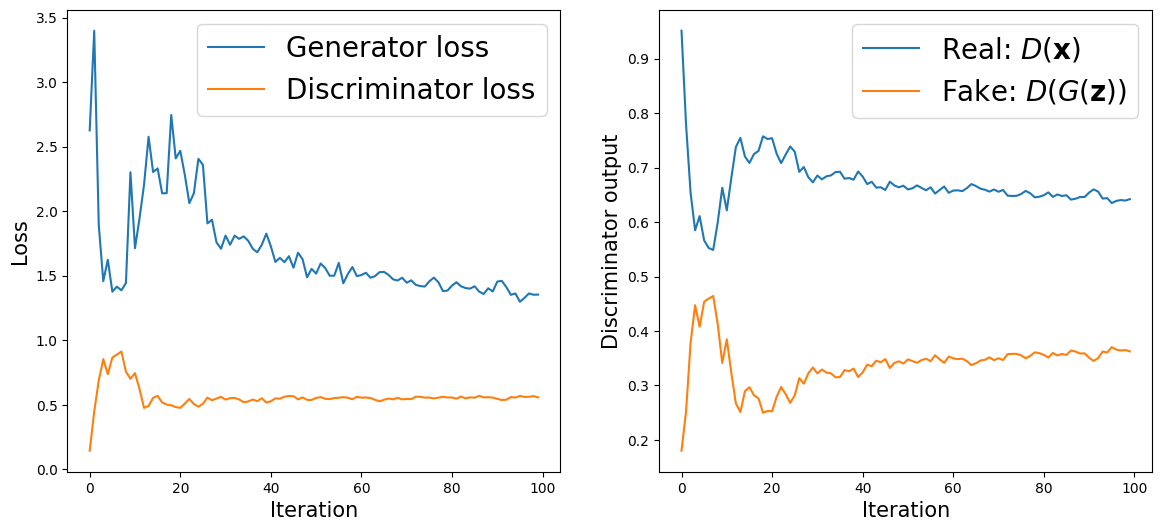

In [14]:
import itertools


fig = plt.figure(figsize=(14, 6))

## Plotting the losses
ax = fig.add_subplot(1, 2, 1)

plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

plt.savefig("/content/drive/MyDrive/GANs/FFGAN/learning_plot.png")
plt.show()

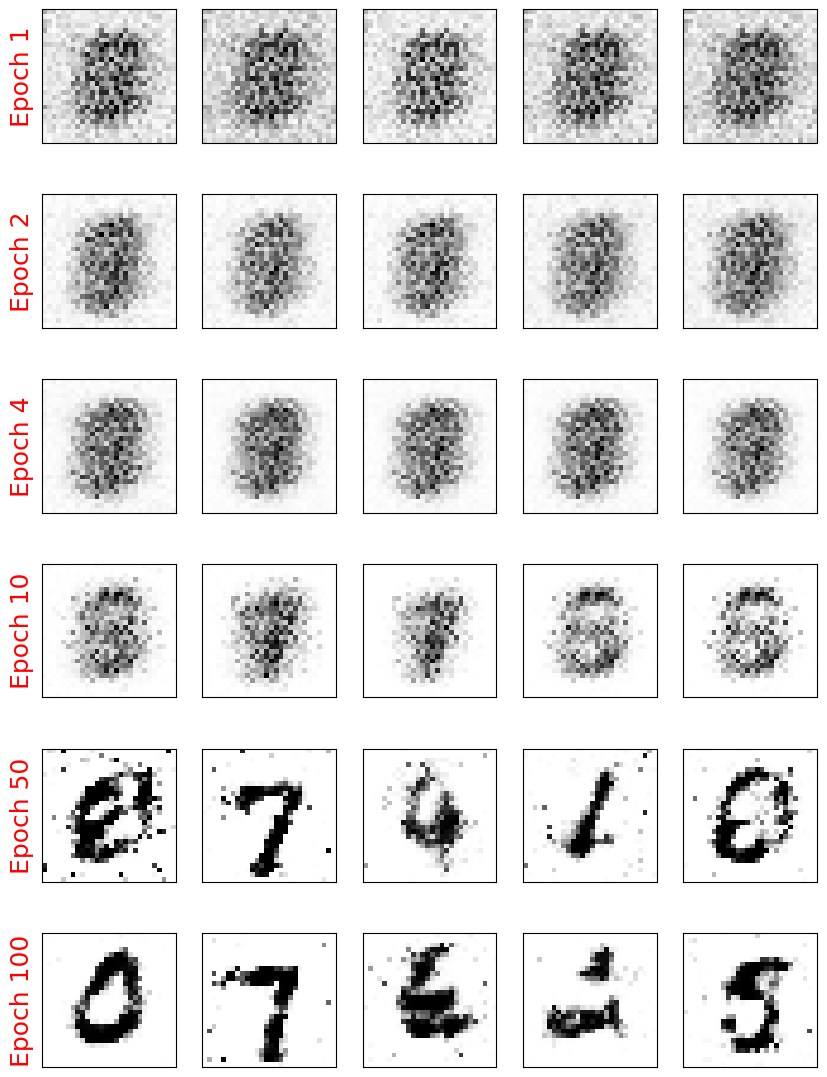

In [15]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e-1][j]
        ax.imshow(image.squeeze(), cmap='gray_r')

plt.savefig("/content/drive/MyDrive/GANs/FFGAN/sample_plot.png")
plt.show()

In [16]:
# saving
torch.save(gen_model.state_dict(), "/content/drive/MyDrive/GANs/FFGAN/generator_model.pth")
torch.save(disc_model.state_dict(), "/content/drive/MyDrive/GANs/FFGAN/discriminator_model.pth")
